In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [3]:
def generate_random_stock_data(num_stocks = 50, num_days = 1000, num_sectors = 5):

    market_trend = np.cumsum(np.random.normal(0,0.5,num_days))
    sector_trend = {i:np.cumsum(np.random.normal(0,0.3,num_days)) for i in range(num_sectors)}
    stock_specific = np.random.normal(0,0.2,(num_days,num_stocks))

    stock_sector_mapping = np.random.choice(range(num_sectors),num_stocks)

    stock_data = np.zeros((num_days,num_stocks))

    for i in range(num_stocks):
        stock_data[:,i] = 0.5*market_trend + 0.3*sector_trend[stock_sector_mapping[i]] + 0.2*stock_specific[:,i]

    stock_df = pd.DataFrame(stock_data, columns = [f'Stock_{i+1}' for i in range(num_stocks)])
    stock_df.index = pd.date_range(start = '2015-01-01', periods = num_days, freq = 'D')

    return stock_df, market_trend, sector_trend, stock_specific

In [4]:
#generating random sample data with clear trends
data,market_trend, sector_trend, stock_specific = generate_random_stock_data()
#data.head()

In [5]:
data.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5,Stock_6,Stock_7,Stock_8,Stock_9,Stock_10,...,Stock_41,Stock_42,Stock_43,Stock_44,Stock_45,Stock_46,Stock_47,Stock_48,Stock_49,Stock_50
2015-01-01,0.001901,0.021227,0.048358,0.041493,0.241555,0.283607,0.033618,0.186695,0.295723,0.216637,...,0.288284,0.134779,0.134545,0.071796,0.090423,0.046755,0.063492,0.013791,0.032240,0.028971
2015-01-02,0.064177,0.049891,-0.003858,0.050016,0.312420,0.358782,0.012070,0.339797,0.404452,0.322695,...,0.328586,0.014408,0.002582,-0.024181,0.013553,0.045369,-0.029894,-0.156026,0.019989,-0.012883
2015-01-03,0.149119,0.181858,-0.034356,0.120441,0.430246,0.508574,0.266146,0.431630,0.487429,0.436991,...,0.446690,0.009144,0.171971,0.038314,0.034611,0.097640,0.108990,-0.049698,-0.048123,0.116748
2015-01-04,0.671615,0.560579,0.331109,0.424656,0.817577,0.806533,0.589586,0.751873,0.792289,0.726009,...,0.831914,0.318975,0.568976,0.400332,0.253526,0.453507,0.402252,0.496760,0.350078,0.445155
2015-01-05,0.392282,0.370486,0.461123,0.305220,0.746413,0.856180,0.398393,0.798063,0.790364,0.766505,...,0.784234,0.331877,0.467674,0.406604,0.345250,0.250433,0.252018,0.533066,0.301676,0.270786


In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
market_trend_scaled = np.mean(scaled_data, axis=1)

In [17]:
# Kernel PCA with RBF
k = 5
kpca = KernelPCA(n_components=k,kernel='rbf',gamma=0.01)
X_kpca = kpca.fit_transform(scaled_data)

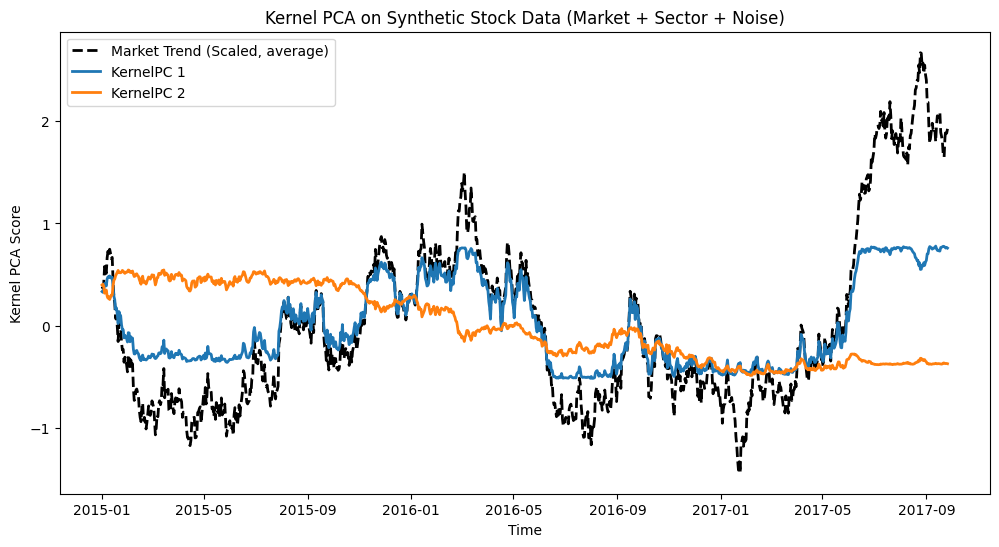

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, market_trend_scaled, label="Market Trend (Scaled, average)", color="black", linestyle="dashed", linewidth=2)
plt.plot(data.index, X_kpca[:, 0], label="KernelPC 1", linewidth=2)
plt.plot(data.index, X_kpca[:, 1], label="KernelPC 2", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Kernel PCA Score")
plt.title("Kernel PCA on Synthetic Stock Data (Market + Sector + Noise)")
plt.legend()
plt.show()

In [10]:
gammas = np.linspace(0.001, 1, 1000)

max_corr = 0
best_gamma = None

for g in gammas:
    kpca = KernelPCA(n_components=5, kernel='rbf', gamma=g)
    X_kpca = kpca.fit_transform(scaled_data) 
    # Compute correlation between the first Kernel PC and the scaled market trend
    corr = np.corrcoef(X_kpca[:, 0], market_trend_scaled)[0, 1]
    if abs(corr) > abs(max_corr): # avoiding sign flips
        max_corr = corr
        best_gamma = g

print(f"Best gamma: {best_gamma:.4f} with correlation: {max_corr:.4f}")

Best gamma: 0.0010 with correlation: 0.9987


In [14]:
import itertools

kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
gammas = np.linspace(0.0001, 1, 1000)

best_kernel = None
best_gamma = None
max_corr = 0

for kernel, gamma in itertools.product(kernels, gammas):
    # Some kernels do not use gamma (like linear and cosine), so we skip gamma for them
    if kernel in ['linear', 'cosine']:
        kpca = KernelPCA(n_components=5, kernel=kernel)
    else:
        kpca = KernelPCA(n_components=5, kernel=kernel, gamma=gamma)

    X_kpca = kpca.fit_transform(scaled_data)  

    # Compute correlation with market trend
    corr = np.corrcoef(X_kpca[:, 0], market_trend_scaled)[0, 1]

    # Track the best (kernel, gamma) combination
    if abs(corr) > abs(max_corr):
        max_corr = corr
        best_kernel = kernel
        best_gamma = gamma if kernel not in ['linear', 'cosine'] else None

print(f"Best Kernel: {best_kernel}, Best Gamma: {best_gamma}, Max Correlation: {max_corr:.4f}")

Best Kernel: rbf, Best Gamma: 0.0001, Max Correlation: 0.9992
